In [1]:
import pandas as pd
import torch
from torch import cuda
import seqeval
from seqeval.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from transformers import AutoTokenizer, AutoModelForTokenClassification, AdamW, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import evaluate
import numpy as np
from datasets import load_dataset
import ast

In [2]:
# 60 train, 20 dev, 20 test
train_df = pd.read_csv('data/processed/phee/ace/train_w_test_tag_new_mapped.csv')
dev_df = pd.read_csv('data/processed/phee/ace/dev_w_test_tag_new_mapped.csv')
test_df = pd.read_csv('data/processed/phee/ace/test_w_test_tag_new_mapped.csv')


train_df = train_df[['Sentence', 'Med_Tag']]
train_df.rename(columns={"Sentence": "sentence", "Med_Tag": "tag"}, inplace=True)
dev_df = dev_df[['Sentence', 'Med_Tag']]
dev_df.rename(columns={"Sentence": "sentence", "Med_Tag": "tag"}, inplace=True)
test_df = test_df[['Sentence', 'Med_Tag']]
test_df.rename(columns={"Sentence": "sentence", "Med_Tag": "tag"}, inplace=True)

train_df['sentence'] = train_df['sentence'].apply(lambda x: x.split())
train_df['tag'] = train_df['tag'].apply(lambda x: x.split())
dev_df['sentence'] = dev_df['sentence'].apply(lambda x: x.split())
dev_df['tag'] = dev_df['tag'].apply(lambda x: x.split())
test_df['sentence'] = test_df['sentence'].apply(lambda x: x.split())
test_df['tag'] = test_df['tag'].apply(lambda x: x.split())

# train_dev_df = pd.concat([train_df, dev_df], ignore_index=True)

# save to csv
train_df.to_csv('data/processed/phee/ace/final_train.csv', index=False) # final_train is train+dev
dev_df.to_csv('data/processed/phee/ace/final_dev.csv', index=False) # final_dev is test
test_df.to_csv('data/processed/phee/ace/final_test.csv', index=False) # final_test is test
# train_dev_df


In [3]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
dataset = load_dataset('csv', data_files={'train': 'data/processed/phee/ace/final_train.csv', 'validation': 'data/processed/phee/ace/final_dev.csv', 'test': 'data/processed/phee/ace/final_test.csv'})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [5]:
unique_tags = pd.unique([tag for sublist in train_df['tag'] for tag in sublist])
# Create label2id dictionary
print(unique_tags)
label2id = {tag: id for id, tag in enumerate(unique_tags)}

# Create id2label dictionary by swapping keys with values
id2label = {id: tag for tag, id in label2id.items()}

# Print the dictionaries
print("label2id:", label2id)
print("id2label:", id2label)

['O' 'I-Treatment' 'I-Test' 'I-Problem' 'I-Background' 'I-Other']
label2id: {'O': 0, 'I-Treatment': 1, 'I-Test': 2, 'I-Problem': 3, 'I-Background': 4, 'I-Other': 5}
id2label: {0: 'O', 1: 'I-Treatment', 2: 'I-Test', 3: 'I-Problem', 4: 'I-Background', 5: 'I-Other'}


In [6]:
train_df['sentence']

0       [objective, :, to, test, the, hypothesis, that...
1       [an, evaluation, of, ovarian, structure, and, ...
2       [phenobarbital, hepatotoxicity, in, an, 8, -, ...
3       [the, authors, report, a, case, of, balint, sy...
4       [according, to, the, naranjo, probability, sca...
                              ...                        
2788    [l, -, t4, stimulated, lymphocyte, transformat...
2789    [a, 53, -, year, -, old, man, developed, lower...
2790    [a, mentally, retarded, 23, -, year, -, old, w...
2791    [after, 5, days, of, treatment, with, il, -, 2...
2792    [acute, pancreatitis, after, long, -, term, 5,...
Name: sentence, Length: 2793, dtype: object

In [7]:
def transform(example_batch):
    example_batch['sentence'] = ast.literal_eval(example_batch['sentence'])
    example_batch['tag'] = ast.literal_eval(example_batch['tag'])
    example_batch['tag'] = [label2id[label] for label in example_batch['tag']]
    return example_batch

for type in ['train', 'validation', 'test']:
    dataset[type] = dataset[type].map(transform)

Map:   0%|          | 0/2793 [00:00<?, ? examples/s]

Map:   0%|          | 0/918 [00:00<?, ? examples/s]

Map:   0%|          | 0/968 [00:00<?, ? examples/s]

In [8]:
tokenizer = AutoTokenizer.from_pretrained("samrawal/bert-base-uncased_clinical-ner")

In [9]:
inputs = tokenizer(dataset['train'][0]['sentence'], is_split_into_words=True)
inputs.tokens()
inputs.word_ids()

[None,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 8,
 9,
 10,
 11,
 11,
 12,
 13,
 14,
 15,
 16,
 16,
 17,
 18,
 19,
 20,
 21,
 21,
 21,
 21,
 21,
 22,
 23,
 23,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 31,
 31,
 31,
 31,
 32,
 33,
 34,
 34,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 None]

In [10]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            new_labels.append(label)

    return new_labels

In [11]:
labels =  dataset['train'][0]['tag']
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0]
[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 2, 2, 2, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, -100]


In [12]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["sentence"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["tag"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [13]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [14]:
tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset['train'].column_names,
)

Map:   0%|          | 0/2793 [00:00<?, ? examples/s]

Map:   0%|          | 0/918 [00:00<?, ? examples/s]

Map:   0%|          | 0/968 [00:00<?, ? examples/s]

In [15]:
tokenized_datasets.column_names

{'train': ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
 'validation': ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
 'test': ['input_ids', 'token_type_ids', 'attention_mask', 'labels']}

In [16]:
batch = data_collator([tokenized_datasets['train'][i] for i in range(2)])
batch["labels"]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    1,    0,    0,    2,    2,    2,    2,    2,    0,    0,
            3,    3,    3,    0,    0,    0,    0,    0,    0, -100],
        [-100,    0,    2,    2,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    4,    4,    4,    4,    0,    0,    0,    1,    1,    1,
            1,    3,    3,    3,    0,    0,    0,    0,    0,    3,    3,    3,
            3,    3,    3,    0,    0,    0, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

In [17]:
metric = evaluate.load("seqeval")

In [18]:
predictions = ['O', 'B-LOC', 'I-LOC', 'I-LOC', 'O']
references = ['O', 'B-LOC', 'I-LOC', 'O', 'O']

In [19]:
from sklearn.metrics import classification_report
r = classification_report(y_pred = predictions, y_true=references, output_dict=True)
r

{'B-LOC': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1.0},
 'I-LOC': {'precision': 0.5,
  'recall': 1.0,
  'f1-score': 0.6666666666666666,
  'support': 1.0},
 'O': {'precision': 1.0,
  'recall': 0.6666666666666666,
  'f1-score': 0.8,
  'support': 3.0},
 'accuracy': 0.8,
 'macro avg': {'precision': 0.8333333333333334,
  'recall': 0.8888888888888888,
  'f1-score': 0.8222222222222223,
  'support': 5.0},
 'weighted avg': {'precision': 0.9,
  'recall': 0.8,
  'f1-score': 0.8133333333333332,
  'support': 5.0}}

In [20]:
r['weighted avg']['f1-score']
r['accuracy']
r['f1-score_wo_O'] = (r['B-LOC']['f1-score'] + r['I-LOC']['f1-score'] ) / 2
r['macro_wo_O'] = {'precision': 0.8333333333333334,
  'recall': 0.8888888888888888,
  'f1-score': 0.8222222222222223,
  'support': 5.0}
dfr = pd.DataFrame(r)

# Round all numbers to 3 decimal places
df_rounded = dfr.round(3).T

In [21]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    # report = classification_report(true_labels, true_predictions, output_dict=True)

    # # Flatten the sequences
    # flat_true = [label for seq in true_labels for label in seq]
    # flat_pred = [label for seq in true_predictions for label in seq]
    # print(report.items())
    # accuracies = {}
    # for label, metrics in report.items():
    #     if label not in ["micro avg", "macro avg", "weighted avg"]:
    #         correct_predictions = sum([1 for t, p in zip(flat_true, flat_pred) if t == 'I-' + label and p == 'I-' + label])
    #         print(correct_predictions)
    #         accuracies[label] = correct_predictions / metrics['support']

    flat_true = [label for seq in true_labels for label in seq]
    flat_pred = [label for seq in true_predictions for label in seq]
    report = classification_report(y_pred=flat_pred, y_true=flat_true, output_dict=True)
    report['macro_wo_O'] = {'precision': (report['I-Background']['precision'] + report['I-Other']['precision'] + report['I-Problem']['precision'] + report['I-Test']['precision'] + report['I-Treatment']['precision']) / 5,
    'recall': (report['I-Background']['recall'] + report['I-Other']['recall'] + report['I-Problem']['recall'] + report['I-Test']['recall'] + report['I-Treatment']['recall']) / 5,
    'f1-score': (report['I-Background']['f1-score'] + report['I-Other']['f1-score'] + report['I-Problem']['f1-score'] + report['I-Test']['f1-score'] + report['I-Treatment']['f1-score']) / 5,
    'support': (report['I-Background']['support'] + report['I-Other']['support'] + report['I-Problem']['support'] + report['I-Test']['support'] + report['I-Treatment']['support'])}

  
    
    report_df = pd.DataFrame(report).round(3).T



    # accuracy_score_val = accuracy_score(y_true=true_labels, y_pred=true_predictions)
    cm = confusion_matrix(y_pred=flat_pred, y_true=flat_true)
    disp = ConfusionMatrixDisplay(cm, display_labels=np.array(['I-Background','I-Other', 'I-Problem', 'I-Test', 'I-Treatment', 'O']))
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax)

    # Save the figure to an image file
    plt.savefig('analysis/graphs/confusion_matrix.png')
    plt.show()
    print(report_df)
    # save all_metrics to file
    with open("analysis/reports/all_metrics.txt", "w") as f:
        f.write(str(all_metrics))
        # save report to file
        f.write(str(report_df))

    return {
        # "precision": all_metrics["overall_precision"],
        # "recall": all_metrics["overall_recall"],
        # "f1": all_metrics["overall_f1"],
        # "accuracy": all_metrics["overall_accuracy"],
        "precision": report['macro avg']['precision'],
        "recall": report['macro avg']['recall'],
        "f1": report['macro avg']['f1-score'],
        "accuracy": report['accuracy'],
    }

In [22]:
model = AutoModelForTokenClassification.from_pretrained(
    'samrawal/bert-base-uncased_clinical-ner',
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at samrawal/bert-base-uncased_clinical-ner and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# from huggingface_hub import notebook_login

# notebook_login()

In [24]:
from transformers import TrainingArguments

# args = TrainingArguments(
#     "bert-finetuned-ner",
#     overwrite_output_dir=True,
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=2e-5,
#     num_train_epochs=5,
#     weight_decay=0.01,
# )

In [25]:
args = TrainingArguments(
    "bert-finetuned-ner",
    overwrite_output_dir=True,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=False,
    learning_rate=1e-5,
    num_train_epochs=5,
    logging_strategy="epoch",
)

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.542700,0.402206,0.765559,0.803111,0.781389,0.855032
2,0.338900,0.377859,0.771190,0.813258,0.789478,0.860826
3,0.283300,0.374574,0.795858,0.816845,0.805344,0.866518
4,0.245000,0.377914,0.799149,0.810911,0.803285,0.868850
5,0.219600,0.382123,0.799001,0.818955,0.807360,0.868987


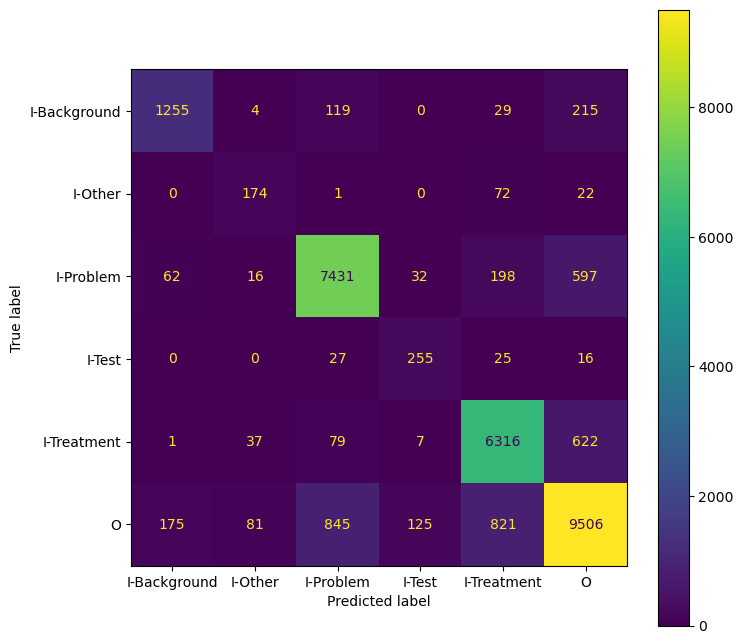

              precision  recall  f1-score    support
I-Background      0.841   0.774     0.806   1622.000
I-Other           0.558   0.647     0.599    269.000
I-Problem         0.874   0.891     0.883   8336.000
I-Test            0.609   0.789     0.687    323.000
I-Treatment       0.847   0.894     0.870   7062.000
O                 0.866   0.823     0.844  11553.000
accuracy          0.855   0.855     0.855      0.855
macro avg         0.766   0.803     0.781  29165.000
weighted avg      0.856   0.855     0.855  29165.000
macro_wo_O        0.745   0.799     0.769  17612.000


/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


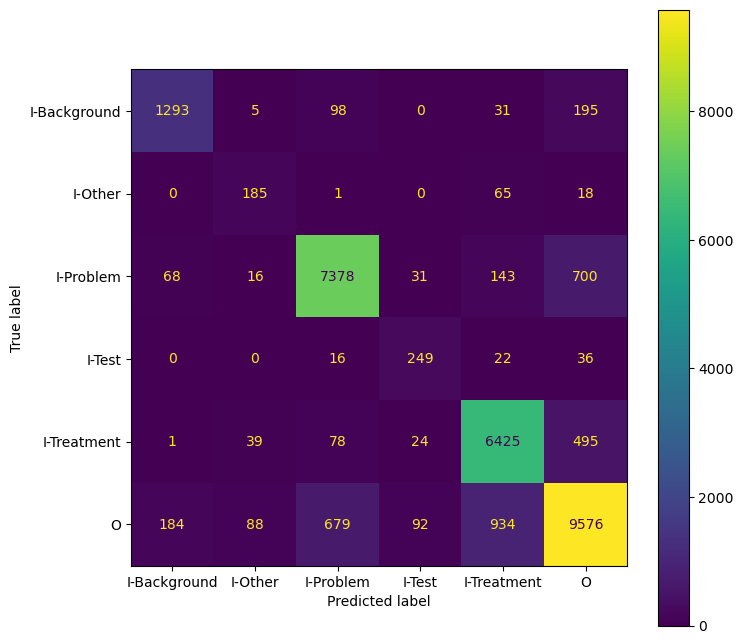

              precision  recall  f1-score    support
I-Background      0.836   0.797     0.816   1622.000
I-Other           0.556   0.688     0.615    269.000
I-Problem         0.894   0.885     0.890   8336.000
I-Test            0.629   0.771     0.693    323.000
I-Treatment       0.843   0.910     0.875   7062.000
O                 0.869   0.829     0.848  11553.000
accuracy          0.861   0.861     0.861      0.861
macro avg         0.771   0.813     0.789  29165.000
weighted avg      0.863   0.861     0.861  29165.000
macro_wo_O        0.752   0.810     0.778  17612.000


/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


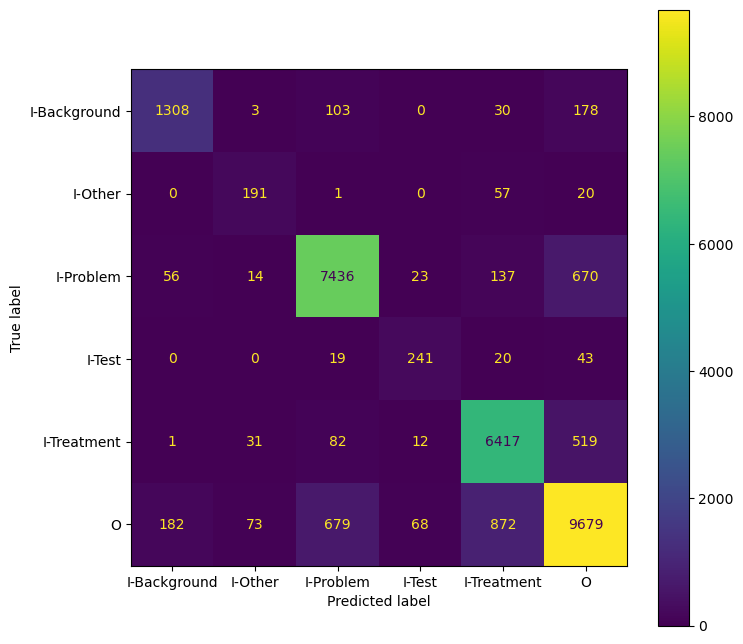

              precision  recall  f1-score    support
I-Background      0.846   0.806     0.825   1622.000
I-Other           0.612   0.710     0.657    269.000
I-Problem         0.894   0.892     0.893   8336.000
I-Test            0.701   0.746     0.723    323.000
I-Treatment       0.852   0.909     0.879   7062.000
O                 0.871   0.838     0.854  11553.000
accuracy          0.867   0.867     0.867      0.867
macro avg         0.796   0.817     0.805  29165.000
weighted avg      0.867   0.867     0.866  29165.000
macro_wo_O        0.781   0.813     0.796  17612.000


/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


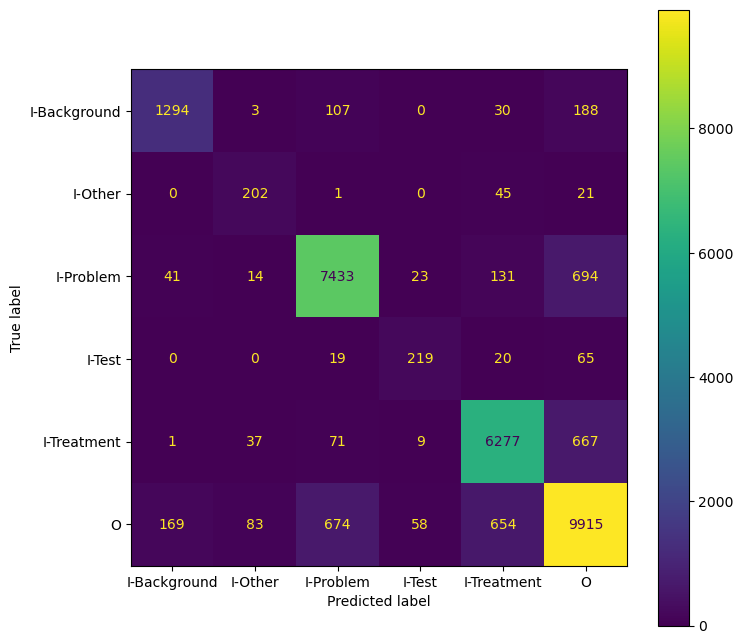

              precision  recall  f1-score    support
I-Background      0.860   0.798     0.828   1622.000
I-Other           0.596   0.751     0.664    269.000
I-Problem         0.895   0.892     0.893   8336.000
I-Test            0.709   0.678     0.693    323.000
I-Treatment       0.877   0.889     0.883   7062.000
O                 0.858   0.858     0.858  11553.000
accuracy          0.869   0.869     0.869      0.869
macro avg         0.799   0.811     0.803  29165.000
weighted avg      0.869   0.869     0.869  29165.000
macro_wo_O        0.787   0.801     0.792  17612.000


/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


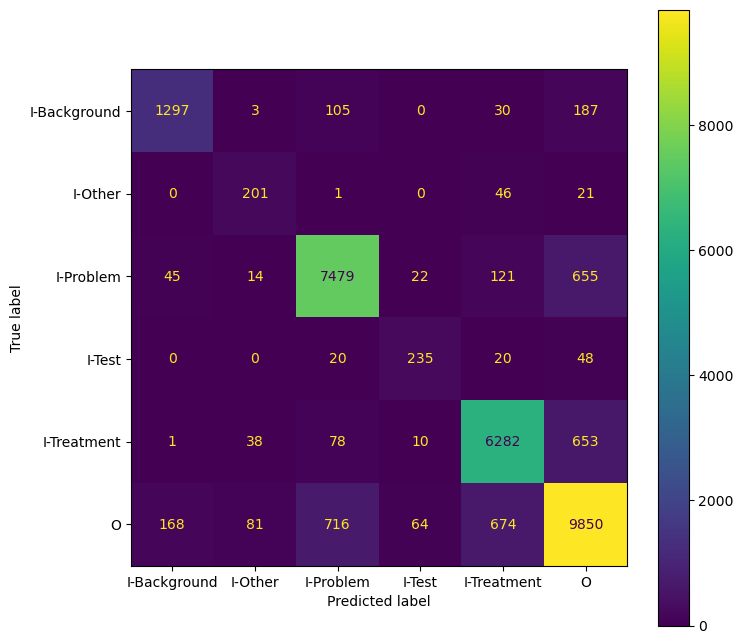

              precision  recall  f1-score    support
I-Background      0.858   0.800     0.828   1622.000
I-Other           0.596   0.747     0.663    269.000
I-Problem         0.890   0.897     0.894   8336.000
I-Test            0.710   0.728     0.719    323.000
I-Treatment       0.876   0.890     0.883   7062.000
O                 0.863   0.853     0.858  11553.000
accuracy          0.869   0.869     0.869      0.869
macro avg         0.799   0.819     0.807  29165.000
weighted avg      0.870   0.869     0.869  29165.000
macro_wo_O        0.786   0.812     0.797  17612.000


TrainOutput(global_step=1750, training_loss=0.3259278390066964, metrics={'train_runtime': 416.8413, 'train_samples_per_second': 33.502, 'train_steps_per_second': 4.198, 'total_flos': 394553487917772.0, 'train_loss': 0.3259278390066964, 'epoch': 5.0})

In [26]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


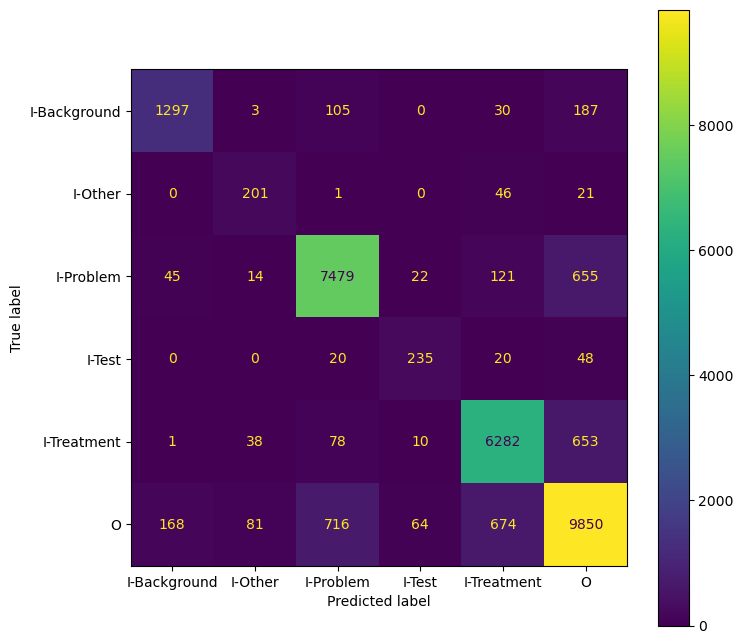

              precision  recall  f1-score    support
I-Background      0.858   0.800     0.828   1622.000
I-Other           0.596   0.747     0.663    269.000
I-Problem         0.890   0.897     0.894   8336.000
I-Test            0.710   0.728     0.719    323.000
I-Treatment       0.876   0.890     0.883   7062.000
O                 0.863   0.853     0.858  11553.000
accuracy          0.869   0.869     0.869      0.869
macro avg         0.799   0.819     0.807  29165.000
weighted avg      0.870   0.869     0.869  29165.000
macro_wo_O        0.786   0.812     0.797  17612.000
Validation Accuracy: 0.8689867992456711


In [27]:
evaluation_results = trainer.evaluate()

validation_accuracy = evaluation_results['eval_accuracy']
print(f"Validation Accuracy: {validation_accuracy}")

In [28]:
# trainer.push_to_hub(commit_message="Training complete")

In [29]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=8
)

In [30]:
model = AutoModelForTokenClassification.from_pretrained(
    'samrawal/bert-base-uncased_clinical-ner',
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at samrawal/bert-base-uncased_clinical-ner and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [32]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [33]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [34]:
# from huggingface_hub import Repository, get_full_repo_name

# model_name = "bert-finetuned-ner-accelerate"
# repo_name = get_full_repo_name(model_name)
# repo_name

In [35]:
output_dir = "bert-finetuned-ner-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

NameError: name 'Repository' is not defined

In [ ]:
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

: 